In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm


In [2]:
import pandas as pd

data = pd.read_excel("/content/final_4000_unique_technical_support_qa.xlsx")

print(data.head())

                                            Question  \
0  Could you guide me through solving software tr...   
1  What should I do to address the problem of acc...   
2  What actions are necessary for fixing mobile d...   
3  Could you guide me through solving mobile devi...   
4  Could you guide me through solving device perf...   

                                              Answer  
0  Restart the software, check for updates, and r...  
1  Follow the account setup wizard and provide ac...  
2  Restart the device, check for updates, and cle...  
3  Restart the device, check for updates, and cle...  
4  Close unused programs, update the system, and ...  


In [3]:

print("\nDataset Info:")
print(data.info())



print("\nMissing Values:")
print(data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  4000 non-null   object
 1   Answer    4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None

Missing Values:
Question    0
Answer      0
dtype: int64


First 5 rows of the dataset:
                                             Question  \
0  Could you guide me through solving software tr...   
1  What should I do to address the problem of acc...   
2  What actions are necessary for fixing mobile d...   
3  Could you guide me through solving mobile devi...   
4  Could you guide me through solving device perf...   

                                              Answer  
0  Restart the software, check for updates, and r...  
1  Follow the account setup wizard and provide ac...  
2  Restart the device, check for updates, and cle...  
3  Restart the device, check for updates, and cle...  
4  Close unused programs, update the system, and ...  


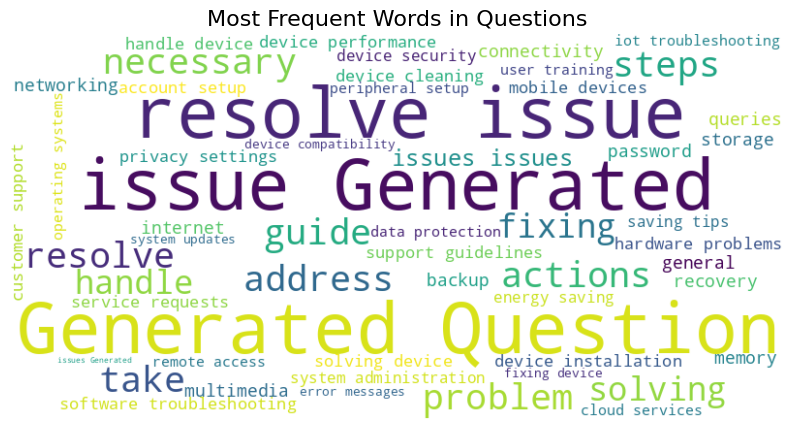

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Load the dataset
df = pd.read_excel("/content/final_4000_unique_technical_support_qa.xlsx")  # Replace with your file name

# Display the first 5 rows to ensure data is loaded correctly
print("First 5 rows of the dataset:\n", df.head())

# Check for the correct column name
column_name = "Rephrased Question" if "Rephrased Question" in df.columns else "Question"

if column_name not in df.columns:
    print(f" Error: The column '{column_name}' is not found in the dataset. Check the column names.")
else:
    # Ensure the column contains text data
    if df[column_name].dtype != "object":
        print(f"Warning: The column '{column_name}' contains numerical or non-text data.")
    else:
        # Convert the column to a single text string
        all_text = " ".join(df[column_name].dropna().astype(str))

        if not all_text.strip():
            print(" Warning: No words available to generate a word cloud.")
        else:
            # Define stopwords
            stopwords = set(STOPWORDS)
            stopwords.update(["the", "?", "is", "are", "a", "of", "to", "in"])  # Add more common words to exclude

            # Generate the word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color="white",
                stopwords=stopwords,
                colormap="viridis"
            ).generate(all_text)

            # Display the word cloud
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title("Most Frequent Words in Questions", fontsize=16)
            plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel("/content/technical_support_QA_400.xlsx")   # Replace with your actual dataset

# Define the target column (change if needed)
column_name = "Question"  # Replace with the desired column name

if column_name not in df.columns:
    print(f"Error: Column '{column_name}' not found in the dataset.")
else:
    # Handle missing values
    df[column_name] = df[column_name].fillna("")

    # Split text into words and get lengths
    words = df[column_name].str.split().explode()  # Flatten words into a single list

    if words.empty:
        print(" No words found in the dataset.")
    else:
        # Find the longest and shortest words
        longest_word = max(words, key=len)
        shortest_word = min(words, key=len)

        print(f" Longest Word: {longest_word} (Length: {len(longest_word)})")
        print(f" Shortest Word: {shortest_word} (Length: {len(shortest_word)})")


 Longest Word: troubleshooting (Length: 15)
 Shortest Word: I (Length: 1)


In [6]:
label_encoder = LabelEncoder()
data["answers_encoded"] = label_encoder.fit_transform(data["Answer"])

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["Question"].values, data["answers_encoded"].values, # Use encoded labels
    test_size=0.2, random_state=42
)

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


**Bert**

In [10]:
batch_size = 16
max_len = 128  # Define the maximum sequence length

# Create instances of the ClassificationDataset
train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer, max_len)

# Now you can use train_dataset and val_dataset in your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)


In [13]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")

Epoch 0: 100%|██████████| 200/200 [01:05<00:00,  3.04it/s, loss=8.12]


Epoch 0 Loss: 8.27806046962738


Epoch 1: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s, loss=8.29]


Epoch 1 Loss: 8.275193719863891


Epoch 2: 100%|██████████| 200/200 [01:08<00:00,  2.94it/s, loss=8.19]


Epoch 2 Loss: 8.197095510959626


Epoch 3: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s, loss=8.18]


Epoch 3 Loss: 8.15066789150238


Epoch 4: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s, loss=8.14]


Epoch 4 Loss: 8.131346366405488


Epoch 5: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s, loss=8.2]


Epoch 5 Loss: 8.118878161907196


Epoch 6: 100%|██████████| 200/200 [01:08<00:00,  2.93it/s, loss=8.18]


Epoch 6 Loss: 8.108476145267487


Epoch 7: 100%|██████████| 200/200 [01:07<00:00,  2.95it/s, loss=8.2]


Epoch 7 Loss: 8.098895380496979


Epoch 8: 100%|██████████| 200/200 [01:07<00:00,  2.95it/s, loss=8.14]


Epoch 8 Loss: 8.044558005332947


Epoch 9: 100%|██████████| 200/200 [01:07<00:00,  2.94it/s, loss=7.68]

Epoch 9 Loss: 8.003456044197083


In [14]:
def generate_answer_from_finetuned_roberta(user_question):


    inputs = tokenizer(user_question, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}


    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()


    predicted_answer = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_answer


while True:
    user_input = input("Enter your question ('exit' to quit): ").strip()
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break

    answer = generate_answer_from_finetuned_roberta(user_input)
    print(f"Model's Answer: {answer}\n")


Enter your question ('exit' to quit):  How can I resolve the issue of account setup issues?
Model's Answer: Provide step-by-step instructions or training sessions to help users understand the system. If the issue persists, consider consulting a professional or reaching out to technical support for further assistance.

Enter your question ('exit' to quit): my laptop is laging what should i do?
Model's Answer: Follow the setup guide, install necessary drivers, and test the device for functionality. If the issue persists, consider consulting a professional or reaching out to technical support for further assistance.

Enter your question ('exit' to quit): exit
Goodbye!


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9375


In [ ]:
model.save_pretrained("bert_resume_classifier")
tokenizer.save_pretrained("bert_resume_classifier")
torch.save(label_encoder, "label_encoder.pth")


Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


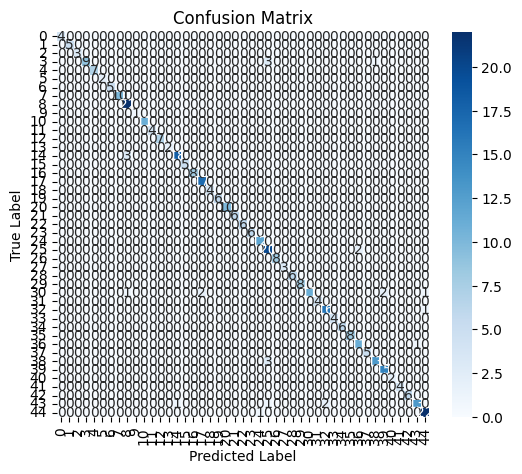

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch


y_true = val_labels
y_pred = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)


        y_pred.extend(predictions.cpu().numpy())


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")  # أو "macro" حسب الحاجة
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Albert

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm


data = pd.read_excel("/content/technical_support_QA_400.xlsx")
label_encoder = LabelEncoder()
data["answers_encoded"] = label_encoder.fit_transform(data["Answer"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["Question"].values, data["answers_encoded"].values,
    test_size=0.2, random_state=42
)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(label_encoder.classes_))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):  # Use __init__ instead of _init_
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # Use __len__ instead of _len_
        return len(self.texts)

    def __getitem__(self, idx):  # Use __getitem__ instead of _getitem_
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


batch_size = 16
max_len = 128
train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


optimizer = AdamW(model.parameters(), lr=1e-5)



Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")

Epoch 0: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s, loss=3.09]


Epoch 0 Loss: 3.499422347545624


Epoch 1: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s, loss=2.53]


Epoch 1 Loss: 2.894019968509674


Epoch 2: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s, loss=2.08]


Epoch 2 Loss: 2.3982465183734893


Epoch 3: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s, loss=1.61]


Epoch 3 Loss: 1.978649023771286


Epoch 4: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s, loss=1.32]


Epoch 4 Loss: 1.6302871692180634


Epoch 5: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s, loss=1.21]


Epoch 5 Loss: 1.3553697323799134


Epoch 6: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s, loss=0.776]


Epoch 6 Loss: 1.0956911492347716


Epoch 7: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s, loss=0.627]


Epoch 7 Loss: 0.8580837047100067


Epoch 8: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s, loss=0.811]


Epoch 8 Loss: 0.7070381185412407


Epoch 9: 100%|██████████| 100/100 [00:35<00:00,  2.82it/s, loss=0.483]

Epoch 9 Loss: 0.5503354665637016


In [ ]:


model.save_pretrained("albert_resume_classifier")
tokenizer.save_pretrained("albert_resume_classifier")
torch.save(label_encoder, "label_encoder.pth")

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification


model = AlbertForSequenceClassification.from_pretrained("albert_resume_classifier")
tokenizer = AlbertTokenizer.from_pretrained("albert_resume_classifier")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def generate_answer_from_finetuned_albert(user_question):

    inputs = tokenizer(user_question, return_tensors="pt", padding=True, truncation=True, max_length=128)


    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)


    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    predicted_answer = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_answer


while True:
    user_input = input(" Enter your question ('exit' to quit): ").strip()
    if user_input.lower() == 'exit':
        print(" Goodbye!")
        break

    answer = generate_answer_from_finetuned_albert(user_input)
    print(f" Model's Answer: {answer}\n")


 Enter your question ('exit' to quit): How can I resolve the issue of account setup issues?
 Model's Answer: Follow the account setup wizard and provide accurate information. If the issue persists, consider consulting a professional or reaching out to technical support for further assistance.

 Enter your question ('exit' to quit): exit
 Goodbye!


Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.92


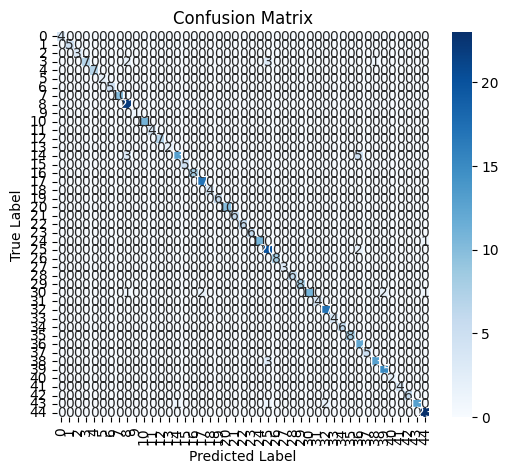

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch


y_true = val_labels
y_pred = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)


        y_pred.extend(predictions.cpu().numpy())


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")  # أو "macro" حسب الحاجة
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**Roberta**

In [ ]:

data = pd.read_excel("/content/technical_support_QA_400.xlsx")


label_encoder = LabelEncoder()
data["answers_encoded"] = label_encoder.fit_transform(data["Answer"])


train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["Question"].values, data["answers_encoded"].values,
    test_size=0.2, random_state=42
)


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=10)
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:

optimizer = AdamW(model.parameters(), lr=2e-5)  # Improved learning rate for better convergence
loss_fn = torch.nn.CrossEntropyLoss()  # Standard loss function for classification tasks


In [ ]:
# ipython-input-3-8e904381a9fa
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# Get the number of unique labels from the label encoder
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
# Set num_labels to the actual number of labels
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")

Epoch 0: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s, loss=3.83]


Epoch 0 Loss: 3.8152927112579347


Epoch 1: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s, loss=3.84]


Epoch 1 Loss: 3.8142816615104675


Epoch 2: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s, loss=3.78]


Epoch 2 Loss: 3.816592674255371


Epoch 3: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s, loss=3.84]


Epoch 3 Loss: 3.8168233585357667


Epoch 4: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s, loss=3.79]


Epoch 4 Loss: 3.8153713512420655


Epoch 5: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s, loss=3.76]


Epoch 5 Loss: 3.8150192666053773


Epoch 6: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s, loss=3.84]


Epoch 6 Loss: 3.8136676287651063


Epoch 7: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s, loss=3.82]


Epoch 7 Loss: 3.816527419090271


Epoch 8: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s, loss=3.86]


Epoch 8 Loss: 3.820318899154663


Epoch 9: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s, loss=3.79]

Epoch 9 Loss: 3.8206992149353027


In [ ]:
# Save the trained RoBERTa model
model.save_pretrained("roberta_resume_classifier")

# Save the RoBERTa tokenizer
tokenizer.save_pretrained("roberta_resume_classifier")

# Save the LabelEncoder for future label conversion
import joblib
joblib.dump(label_encoder, "label_encoder.pth")

print(" Model, tokenizer, and LabelEncoder saved successfully!")


 Model, tokenizer, and LabelEncoder saved successfully!


In [ ]:
def generate_answer_from_finetuned_roberta(user_question):

    # Prepare input for the model
    inputs = tokenizer(user_question, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Pass input through the model
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Convert the predicted label to a textual answer
    predicted_answer = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_answer

# Interactive loop for user input
while True:
    user_input = input(" Enter your question ('exit' to quit): ").strip()
    if user_input.lower() == 'exit':
        print(" Goodbye!")
        break

    answer = generate_answer_from_finetuned_roberta(user_input)
    print(f" Model's Answer: {answer}\n")


 Enter your question ('exit' to quit): How can I resolve the issue of account setup issues?
 Model's Answer: Update the firmware for better performance.

 Enter your question ('exit' to quit): exit
 Goodbye!


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch


y_true = val_labels
y_pred = []


model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device) # Changed 'labels' to 'label'

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)


        y_pred.extend(predictions.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"✅ Model Evaluation Results:")
print(f"📌 Accuracy: {accuracy:.2f}")
print(f"📌 Precision: {precision:.2f}")
print(f"📌 Recall: {recall:.2f}")
print(f"📌 F1 Score: {f1:.2f}")

✅ Model Evaluation Results:
📌 Accuracy: 0.03
📌 Precision: 0.00
📌 Recall: 0.03
📌 F1 Score: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**GPT**

In [ ]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from torch.utils.data import Dataset
from tqdm import tqdm

data_path = "/content/technical_support_QA_400.xlsx"
data = pd.read_excel(data_path)

data = data[['Question', 'Answer']].dropna()

data.rename(columns={'Question': 'text', 'Answer': 'label'}, inplace=True)

data['text'] = data['text'] + " " + data['label']


tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 3. تعريف Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": encoding["input_ids"].squeeze(0)
        }


train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_texts = data['text'][:train_size].tolist()
test_texts = data['text'][train_size:].tolist()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
train_dataset = TextDataset(train_texts, tokenizer)
test_dataset = TextDataset(test_texts, tokenizer)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2_finetuned",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rrrham-75 (rrrham-75-umm-al-qura-university-j-mi-ah-umm-al-qur-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.057600
2,No log,0.046830
3,0.144900,0.043735


TrainOutput(global_step=600, training_loss=0.13065762440363565, metrics={'train_runtime': 288.1424, 'train_samples_per_second': 16.648, 'train_steps_per_second': 2.082, 'total_flos': 313354469376000.0, 'train_loss': 0.13065762440363565, 'epoch': 3.0})

In [ ]:
# After training your model
trainer.save_model("./gpt2_finetuned")  # Save the model
trainer.save_state()

# Save the tokenizer
tokenizer.save_pretrained("./gpt2_finetuned")

('./gpt2_finetuned/tokenizer_config.json',
 './gpt2_finetuned/special_tokens_map.json',
 './gpt2_finetuned/vocab.json',
 './gpt2_finetuned/merges.txt',
 './gpt2_finetuned/added_tokens.json')

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2_finetuned")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2_finetuned")


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the saved model
model_name = "gpt2_finetuned"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate an answer from the fine-tuned model
def generate_answer(user_question, max_length=128):
    inputs = tokenizer(user_question, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, do_sample=True)

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Interactive testing of the model
while True:
    user_input = input(" Enter your question ('exit' to quit): ").strip()
    if user_input.lower() == 'exit':
        print(" Goodbye!")
        break

    answer = generate_answer(user_input)
    print(f" Model's Answer: {answer}\n")


 Enter your question ('exit' to quit): How can I resolve the issue of account setup issues?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Model's Answer: How can I resolve the issue of account setup issues? Follow the account setup wizard and provide accurate information. If the issue persists, consider consulting a professional or reaching out to technical support for further assistance.

 Enter your question ('exit' to quit): exit
 Goodbye!


100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


Validation Loss: 0.0437
Validation Accuracy: 0.8017
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000


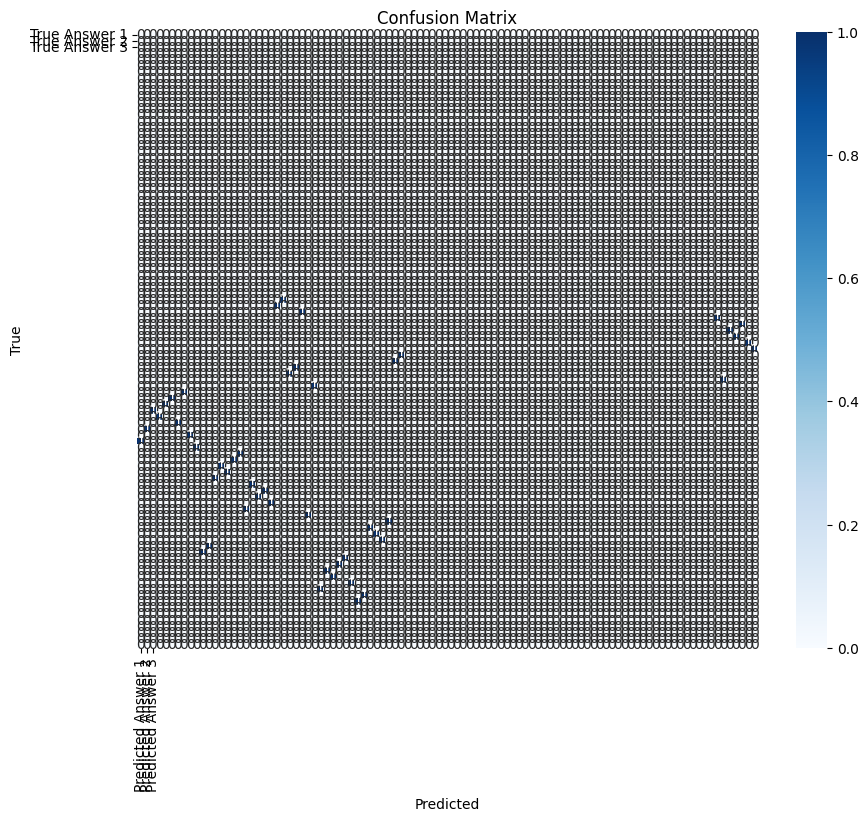

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
total_loss = 0
num_batches = 0
correct_predictions = 0
total_tokens = 0

generated_answers = []
reference_answers = []


with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)


        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1


        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == input_ids).sum().item()
        total_tokens += input_ids.numel()


        generated_answer = tokenizer.decode(predictions[0], skip_special_tokens=True)
        generated_answers.append(generated_answer)

        reference_answer = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        reference_answers.append(reference_answer)

avg_loss = total_loss / num_batches

accuracy = correct_predictions / total_tokens

precision = precision_score(reference_answers, generated_answers, average='weighted', zero_division=1)
recall = recall_score(reference_answers, generated_answers, average='weighted', zero_division=1)
f1 = f1_score(reference_answers, generated_answers, average='weighted', zero_division=1)

print(f"Validation Loss: {avg_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


conf_matrix = confusion_matrix(reference_answers, generated_answers)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Answer 1", "Predicted Answer 2", "Predicted Answer 3"], yticklabels=["True Answer 1", "True Answer 2", "True Answer 3"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
